## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import warnings

from annotations import *
from density_maps import create_and_save_density_maps
from utils.data.data_ops import move_val_split_to_train
from utils.input_output.io import save_np_arrays, load_np_arrays, load_images
from utils.input_output.io import save_gt_counts, load_gt_counts
from utils.preprocessing.misc import gaussian_smoothing

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Datasets

### 2.1 CARPK Dataset

In [4]:
DATASET_PATH = '../../datasets/carpk'
TRAIN_PATH = f'{DATASET_PATH}/train'
TRAIN_IMG_PATH = f'{TRAIN_PATH}/images'
TRAIN_GT_BBS_PATH = f'{TRAIN_PATH}/gt_bbs'
TRAIN_GT_DOTS_PATH = f'{TRAIN_PATH}/gt_dots'
TRAIN_GT_COUNTS_PATH = f'{TRAIN_PATH}/gt_counts'
TRAIN_GT_DENSITY_MAPS_PATH = f'{TRAIN_PATH}/gt_density_maps'

VAL_PATH = f'{DATASET_PATH}/val'

TEST_PATH = f'{DATASET_PATH}/test'
TEST_IMG_PATH = f'{TEST_PATH}/images'
TEST_GT_BBS_PATH = f'{TEST_PATH}/gt_bbs'
TEST_GT_DOTS_PATH = f'{TEST_PATH}/gt_dots'
TEST_GT_COUNTS_PATH = f'{TEST_PATH}/gt_counts'
TEST_GT_DENSITY_MAPS_PATH = f'{TEST_PATH}/gt_density_maps'

# data splitting (initial train and test)
IMAGES_PATH = f'{DATASET_PATH}/initial/Images'
BBS_PATH = f'{DATASET_PATH}/initial/Annotations'
TRAIN_LIST_PATH = f'{DATASET_PATH}/initial/ImageSets/train.txt'
TEST_LIST_PATH = f'{DATASET_PATH}/initial/ImageSets/test.txt'

In [5]:
move_val_split_to_train(VAL_PATH, TRAIN_PATH)

In [6]:
!rm -rf $TRAIN_IMG_PATH
!rm -rf $TRAIN_GT_BBS_PATH
!rm -rf $TRAIN_GT_DOTS_PATH
!rm -rf $TRAIN_GT_DENSITY_MAPS_PATH
!rm -rf $TRAIN_GT_COUNTS_PATH
!rm -rf $TEST_IMG_PATH
!rm -rf $TEST_GT_BBS_PATH
!rm -rf $TEST_GT_DOTS_PATH
!rm -rf $TEST_GT_DENSITY_MAPS_PATH
!rm -rf $TEST_GT_COUNTS_PATH

!mkdir -p $TRAIN_IMG_PATH
!mkdir -p $TRAIN_GT_BBS_PATH
!mkdir $TRAIN_GT_DOTS_PATH
!mkdir $TRAIN_GT_DENSITY_MAPS_PATH
!mkdir $TRAIN_GT_COUNTS_PATH
!mkdir -p $TEST_IMG_PATH
!mkdir -p $TEST_GT_BBS_PATH
!mkdir $TEST_GT_DOTS_PATH
!mkdir $TEST_GT_DENSITY_MAPS_PATH
!mkdir $TEST_GT_COUNTS_PATH

### Split data

#### Load train and test lists

In [7]:
def get_list(split_list):
    with open(split_list, 'r') as fi:
        img_name_list = sorted(fi.read().split())
    return img_name_list

In [8]:
train_list = get_list(TRAIN_LIST_PATH)
test_list = get_list(TEST_LIST_PATH)

print(f'train split: {len(train_list)} images\n', train_list[:3])
print(f'test split: {len(test_list)} images\n', test_list[:3])

train split: 989 images
 ['20160331_NTU_00001', '20160331_NTU_00002', '20160331_NTU_00003']
test split: 459 images
 ['20161225_TPZ_00001', '20161225_TPZ_00002', '20161225_TPZ_00003']


#### Copy images and bounding box annotations

In [9]:
def copy_files(src, dest, filename_list, file_format='png'):
    for filename in filename_list:
        shutil.copy2(f'{src}/{filename}.{file_format}',
                     f'{dest}/{filename}.{file_format}')

In [10]:
copy_files(IMAGES_PATH, TRAIN_IMG_PATH, train_list, 'png')
copy_files(BBS_PATH, TRAIN_GT_BBS_PATH, train_list, 'txt')
copy_files(IMAGES_PATH, TEST_IMG_PATH, test_list, 'png')
copy_files(BBS_PATH, TEST_GT_BBS_PATH, test_list, 'txt')

In [11]:
print(DATASET_PATH)
print(os.listdir(DATASET_PATH))

../../datasets/carpk
['initial', 'test', 'train']


In [12]:
print(TRAIN_PATH)
print(os.listdir(TRAIN_PATH))

../../datasets/carpk/train
['gt_bbs', 'gt_counts', 'gt_density_maps', 'gt_dots', 'images']


In [13]:
train_img_names = sorted(os.listdir(TRAIN_IMG_PATH))
train_gt_bbs_names = sorted(os.listdir(TRAIN_GT_BBS_PATH))

test_img_names = sorted(os.listdir(TEST_IMG_PATH))
test_gt_bbs_names = sorted(os.listdir(TEST_GT_BBS_PATH))

print(f'train split: {len(train_img_names)} images')
print(train_img_names[:3])
print(train_gt_bbs_names[:3])

print(f'\ntest split: {len(test_img_names)} images')
print(test_img_names[:3])
print(test_gt_bbs_names[:3])

train split: 989 images
['20160331_NTU_00001.png', '20160331_NTU_00002.png', '20160331_NTU_00003.png']
['20160331_NTU_00001.txt', '20160331_NTU_00002.txt', '20160331_NTU_00003.txt']

test split: 459 images
['20161225_TPZ_00001.png', '20161225_TPZ_00002.png', '20161225_TPZ_00003.png']
['20161225_TPZ_00001.txt', '20161225_TPZ_00002.txt', '20161225_TPZ_00003.txt']


#### Bounding boxes to dot annotations

In [14]:
train_bbs_list = load_bbs_from_dir(TRAIN_GT_BBS_PATH, train_gt_bbs_names)
test_bbs_list = load_bbs_from_dir(TEST_GT_BBS_PATH, test_gt_bbs_names)

print(len(train_bbs_list), train_bbs_list[67].shape)

989 (43, 4)


In [15]:
train_dots_list = bbs_list_to_dots_list(train_bbs_list)
test_dots_list = bbs_list_to_dots_list(test_bbs_list)

print(len(train_dots_list), len(train_dots_list[67]))
print(train_dots_list[67])

989 43
[(973, 50), (667, 163), (664, 222), (662, 447), (665, 501), (662, 562), (668, 626), (546, 626), (553, 574), (552, 522), (556, 461), (542, 362), (539, 309), (539, 260), (540, 208), (548, 160), (555, 108), (311, 141), (199, 111), (309, 240), (313, 289), (327, 341), (317, 397), (319, 457), (318, 520), (320, 572), (327, 625), (214, 574), (203, 511), (214, 456), (205, 411), (201, 307), (201, 256), (24, 359), (20, 412), (22, 470), (22, 523), (19, 575), (25, 630), (19, 269), (21, 212), (15, 114), (16, 64)]


In [16]:
IMG_SHAPE = (720, 1280)
save_dots_images(train_dots_list, IMG_SHAPE, train_img_names, TRAIN_GT_DOTS_PATH)
save_dots_images(test_dots_list, IMG_SHAPE, test_img_names, TEST_GT_DOTS_PATH)

#### Load dots images (.png)

In [17]:
train_dots_images = load_dots_images(TRAIN_GT_DOTS_PATH, train_img_names)
test_dots_images = load_dots_images(TEST_GT_DOTS_PATH, test_img_names)

print(len(train_dots_images), train_dots_images[0].shape, train_dots_images[0].dtype,
      train_dots_images[0].min(), train_dots_images[0].max(), train_dots_images[0].sum())

989 (720, 1280) float64 0.0 1.0 4.0


#### Save gt counts (from dots images)

In [18]:
train_counts = dots_images_to_counts(train_dots_images)
test_counts = dots_images_to_counts(test_dots_images)

In [19]:
save_gt_counts(train_counts, train_img_names, TRAIN_GT_COUNTS_PATH)
save_gt_counts(test_counts, test_img_names, TEST_GT_COUNTS_PATH)

#### Create and save density maps (.npy)

In [20]:
create_and_save_density_maps(train_dots_images, config.CARPK_SIGMA, train_img_names, TRAIN_GT_DENSITY_MAPS_PATH)
create_and_save_density_maps(test_dots_images, config.CARPK_SIGMA, test_img_names, TEST_GT_DENSITY_MAPS_PATH)

#### Load some test images and density maps

In [21]:
test_images = load_images(TEST_IMG_PATH, test_img_names, num_images=30)
print(len(test_images))
print(test_images[0].dtype)

30
float64


In [22]:
test_gt_density_maps = load_np_arrays(TEST_GT_DENSITY_MAPS_PATH, num=30)
print(len(test_gt_density_maps))
print(test_gt_density_maps[0].dtype)

30
float64


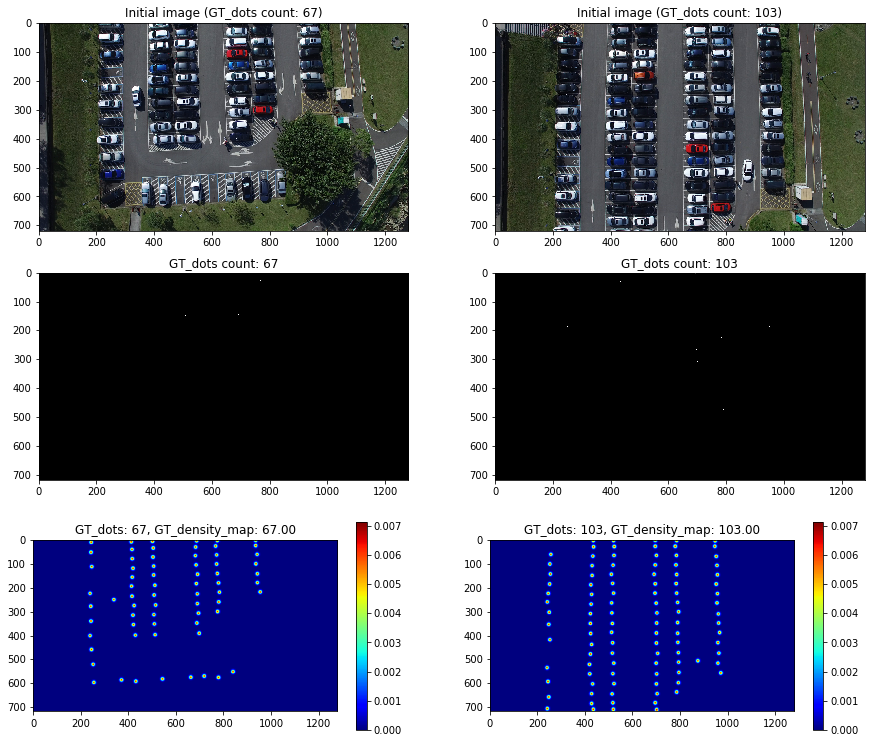

In [23]:
NUM_PLOTS = 2
plt.figure(figsize=(15, 13))
plt.title('CARPK Dataset')

for i in range(NUM_PLOTS):
    count = test_dots_images[10*i].sum().astype(np.int)
    
    plt.subplot(3, NUM_PLOTS, i + 1)
    plt.title(f'Initial image (GT_dots count: {count})')
    plt.imshow(test_images[10*i])
    
    plt.subplot(3, NUM_PLOTS, NUM_PLOTS + i + 1)
    plt.title(f'GT_dots count: {count}')
    plt.imshow(test_dots_images[10*i], cmap='gray')
    
    plt.subplot(3, NUM_PLOTS, 2 * NUM_PLOTS + i + 1)
    plt.title(f'GT_dots: {count}, GT_density_map: {test_gt_density_maps[10*i].sum():.2f}')
    plt.imshow(test_gt_density_maps[10*i], cmap='jet')
    plt.colorbar()